In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
# Load your dataset
# Assuming twitter_cleaned_dataset is already loaded as a pandas DataFrame
twitter_cleaned_dataset = pd.read_csv('twitter_cleaned_dataset.csv')


# Map 'Annotation' to 'oh_label' where sexism -> 1, racism -> 0
twitter_cleaned_dataset['oh_label'] = twitter_cleaned_dataset['Annotation'].map({'sexism': 1, 'racism': 0})

# Split the data into features (X) and target (y)
X = twitter_cleaned_dataset['cleaned_text']
y = twitter_cleaned_dataset['oh_label']


In [5]:
from sklearn.utils import resample

# Concatenate X and y to create a single DataFrame
df = pd.concat([X, y], axis=1)

# Separate the classes
sexism_df = df[df['oh_label'] == 1]
racism_df = df[df['oh_label'] == 0]

# Undersample sexism (majority class) to match the number of racism (minority class)
sexism_undersampled = resample(sexism_df, 
                               replace=False,    # Sample without replacement
                               n_samples=len(racism_df),  # Match the minority class size
                               random_state=42)  # For reproducibility

# Combine the undersampled sexism data with racism data
balanced_df = pd.concat([sexism_undersampled, racism_df])

# Shuffle the data
balanced_df = balanced_df.sample(frac=1, random_state=42)

# Split into features and target again
X_balanced = balanced_df['cleaned_text']
y_balanced = balanced_df['oh_label']

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Fill NaN values with an empty string
X_balanced = X_balanced.fillna('')

# Fit and transform the training data
X_vec = vectorizer.fit_transform(X_balanced)


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialize Logistic Regression with class weight
model = LogisticRegression(class_weight='balanced', random_state=42)

# Train the model
model.fit(X_vec, y_balanced)

# Make predictions on the training data
y_pred = model.predict(X_vec)

# Evaluate the model
print(classification_report(y_balanced, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1970
           1       0.96      0.99      0.98      1970

    accuracy                           0.98      3940
   macro avg       0.98      0.98      0.98      3940
weighted avg       0.98      0.98      0.98      3940



In [8]:
def predict_tweet(tweet, model, vectorizer):
    # Transform the input tweet using the same TF-IDF vectorizer
    tweet_vec = vectorizer.transform([tweet])
    
    # Use the model to predict whether it's sexist (1) or racist (0)
    prediction = model.predict(tweet_vec)
    
    # Return the prediction label
    if prediction == 1:
        return "Sexist"
    else:
        return "Racist"


In [9]:
# User input loop to classify tweets
while True:
    tweet_input = input("Enter a tweet to classify (or type 'exit' to quit): ")
    
    if tweet_input.lower() == 'exit':
        break
    
    # Classify the tweet
    result = predict_tweet(tweet_input, model, vectorizer)
    
    # Output the result
    print(f"The tweet is classified as: {result}")


The tweet is classified as: Racist
The tweet is classified as: Racist
The tweet is classified as: Sexist
The tweet is classified as: Sexist
The tweet is classified as: Sexist
The tweet is classified as: Sexist


KeyboardInterrupt: Interrupted by user

In [ ]:
import joblib


joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [12]:
joblib.dump(model, 'sexism_racism_model.pkl')

['sexism_racism_model.pkl']

In [9]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW  # Corrected import
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

# Step 1: Prepare the Data
# Assuming you already have balanced_df with 'cleaned_text' and 'oh_label'

balanced_df = balanced_df.dropna(subset=['cleaned_text'])  # Drop rows where 'cleaned_text' is NaN
balanced_df = balanced_df[balanced_df['cleaned_text'].str.strip() != '']  # Remove empty strings


# Split the data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    balanced_df['cleaned_text'].tolist(),
    balanced_df['oh_label'].tolist(),
    test_size=0.2,
    random_state=42
)

# Step 2: Tokenize the texts using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create a custom Dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer.encode_plus(
            self.texts[idx],
            add_special_tokens=True,  # Add [CLS] and [SEP] tokens
            max_length=self.max_length,
            padding='max_length',  # Pad to the max length
            truncation=True,  # Truncate texts longer than max_length
            return_tensors='pt',  # Return pytorch tensors
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Step 3: Load the data into DataLoader
train_dataset = TweetDataset(train_texts, train_labels, tokenizer)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Step 4: Load the pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Step 5: Setup optimizer and training device (GPU if available)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

# Step 6: Train the Model
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_loader:
        optimizer.zero_grad()

        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)

    # Print training loss and accuracy for this epoch
    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss}, Accuracy: {accuracy}")

    # Step 7: Validate the Model
    model.eval()
    val_correct_predictions = 0
    val_total_predictions = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits

            preds = torch.argmax(logits, dim=1)
            val_correct_predictions += (preds == labels).sum().item()
            val_total_predictions += labels.size(0)

    val_accuracy = val_correct_predictions / val_total_predictions
    print(f"Validation Accuracy: {val_accuracy}")

# Step 8: Save the model
torch.save(model.state_dict(), 'sexism_racism_bert_model.pth')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 0.1659755674923586, Accuracy: 0.9447619047619048
Validation Accuracy: 0.9631979695431472
Epoch 2/3, Loss: 0.04945090742247548, Accuracy: 0.9834920634920635
Validation Accuracy: 0.9733502538071066
Epoch 3/3, Loss: 0.018548237252625905, Accuracy: 0.9942857142857143
Validation Accuracy: 0.9746192893401016


In [7]:
import torch
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset

# Load the saved model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.load_state_dict(torch.load('sexism_racism_bert_model.pth'))
model.eval()  # Set the model to evaluation mode

from transformers import BertTokenizer

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

import pandas as pd


twitter_data = pd.read_csv('twitter_cleaned_dataset.csv')
# Ensure 'cleaned_text' is a valid column and remove empty rows
twitter_data = twitter_data[twitter_data['cleaned_text'].str.strip() != '']

# Define device (CUDA for GPU or CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load the model to the device
model.to(device)


# Function to predict tweet class
def predict_tweet(tweet):
    encoding = tokenizer.encode_plus(
        tweet,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    # Move the tensors to the same device as the model
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    prediction = torch.argmax(logits, dim=1).item()
    return "Sexist" if prediction == 1 else "Racist"


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# Remove rows where 'cleaned_text' is NaN
twitter_data = twitter_data.dropna(subset=['cleaned_text'])

# Apply the prediction function to each tweet in the 'cleaned_text' column
predictions = twitter_data['cleaned_text'].apply(predict_tweet)

# Add predictions to the dataset
twitter_data['predictions'] = predictions

# Display the first few rows of the updated dataset
print(twitter_data.head())

             formatted_id                                       cleaned_text  \
0  5767-4933-6190-5250-56  muslim mob violence against hindus in banglade...   
1  5678-4332-0338-1249-92  islamophobia is like the idea of naziphobia. i...   
2  5646-0409-0752-0609-92  islam invaded and conquered 2/3 of christiando...   
3  5633-6995-6734-0300-16  do you approve of your pedophile prophet rapin...   
4  5669-8397-0571-5790-08  problem with vile muslims is that they try to ...   

  Annotation  oh_label                                  users hashtags  \
0     racism       1.0                         @AAlwuhaib1977   #Islam   
1     racism       1.0  @jncatron @isra_jourisra @AMPalestine      NaN   
2     racism       1.0                         @HuffPostRelig      NaN   
3     racism       1.0                               @semzyxx      NaN   
4     racism       1.0               @watan71969 @geeky_zekey      NaN   

                    links predictions  
0  http://t.co/C1JBWJwuRc      Rac

In [14]:
# Save the dataset with predictions to a new CSV file
twitter_data.to_csv('twitter_data_with_predictions.csv', index=False)


C:\Users\Jeevan\AppData\Local\Temp\ipykernel_39116\2244107461.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='predictions', data=twitter_data_with_predictions, palette='viridis')


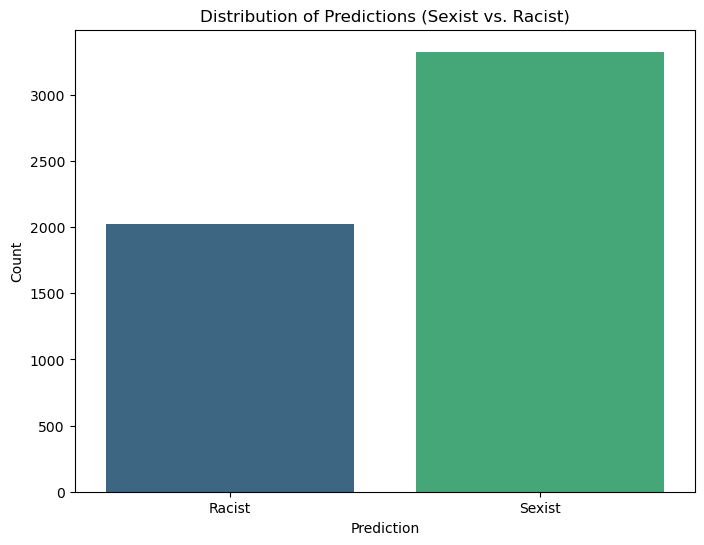

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

twitter_data_with_predictions = pd.read_csv('twitter_data_with_predictions.csv')

# Plot the distribution of the predictions
plt.figure(figsize=(8, 6))
sns.countplot(x='predictions', data=twitter_data_with_predictions, palette='viridis')
plt.title('Distribution of Predictions (Sexist vs. Racist)')
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.show()


In [21]:
from sklearn.metrics import accuracy_score

# Assuming the model's predictions are in 'predictions' column
# Convert 'Sexist' to 1 and 'Racist' to 0 for comparison with 'oh_label' column
twitter_data_with_predictions['predictions_numeric'] = twitter_data_with_predictions['predictions'].apply(lambda x: 1 if x == 'Sexist' else 0)

# Calculate accuracy
accuracy = accuracy_score(twitter_data_with_predictions['oh_label'], twitter_data_with_predictions['predictions_numeric'])
print(f"Accuracy: {accuracy}")


Accuracy: 0.6220767072029935


In [25]:
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertForSequenceClassification

# Load the pre-trained model and tokenizer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.load_state_dict(torch.load('sexism_racism_bert_model.pth'))
model.eval()  # Set the model to evaluation mode

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def get_prediction_probabilities(tweet):
    # Tokenize the tweet
    inputs = tokenizer(tweet, return_tensors='pt', truncation=True, padding=True, max_length=128)
    
    # Get the logits from the model
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
    
    # Apply softmax to get probabilities
    probabilities = F.softmax(logits, dim=1)
    
    # Get the probability for each class
    return probabilities.squeeze().cpu().numpy()

# Apply the function to get prediction probabilities
twitter_data['prediction_probabilities'] = twitter_data['cleaned_text'].apply(lambda x: get_prediction_probabilities(x)[1])  # Probability for "Sexist" class

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


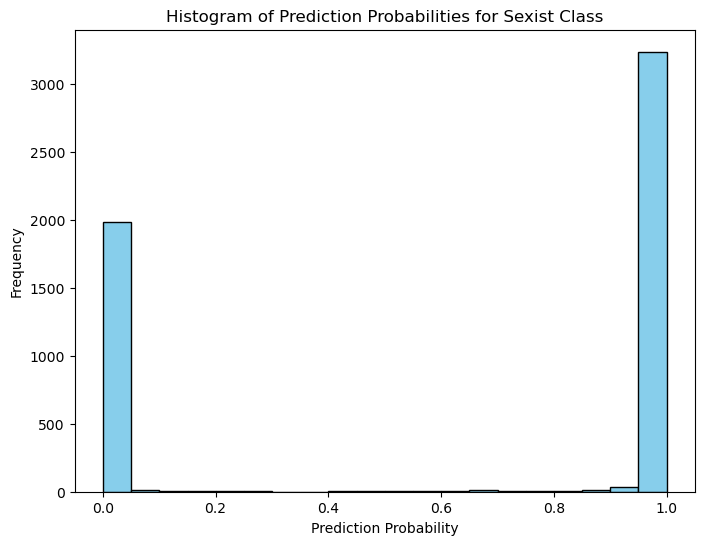

In [26]:
import matplotlib.pyplot as plt

# Plot the histogram of prediction probabilities for the "Sexist" class
plt.figure(figsize=(8, 6))
plt.hist(twitter_data['prediction_probabilities'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Prediction Probabilities for Sexist Class')
plt.xlabel('Prediction Probability')
plt.ylabel('Frequency')
plt.show()


## UMAP for Clustering Sentence Embeddings